In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd

## データ読み込み（ボストン市の住宅価格）

In [29]:
from sklearn.datasets import load_boston
boston = load_boston()
boston.data.shape, boston.target.shape

((506, 13), (506,))

In [30]:
data = np.concatenate((boston.data, boston.target.reshape(506,1)), axis=1)
columns = np.concatenate((boston.feature_names,['house_price']))

In [33]:
df = pd.DataFrame(data = data, columns = columns)
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,house_price
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


## 先ずは相関分析（heatmap）

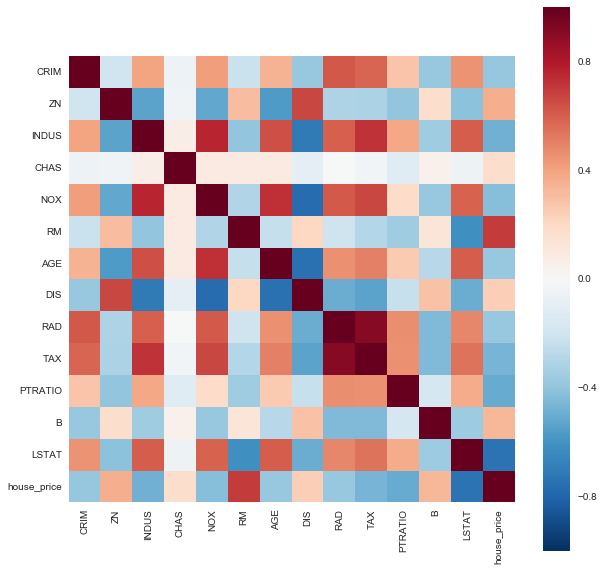

In [39]:
plt.figure(figsize=(10,10))
corrmat = df.corr()
sns.heatmap(corrmat, square=True)

## 相関順に並び替え

In [51]:
k=20
cols = corrmat.nlargest(k, 'house_price').index
cm = np.corrcoef(df[cols].values.T)

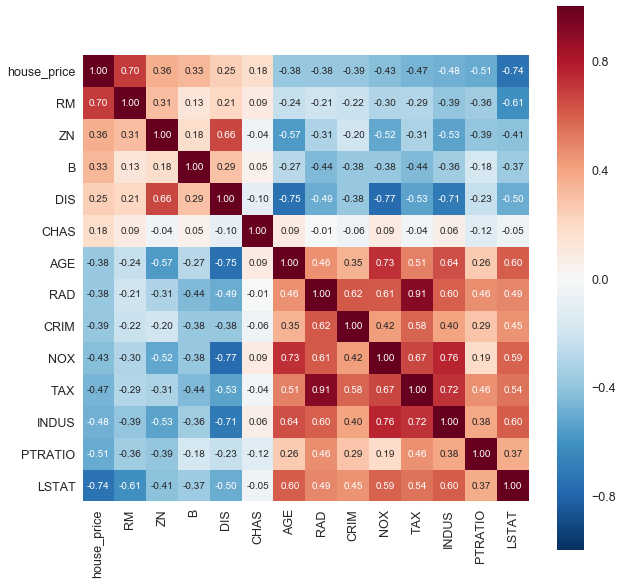

In [48]:
sns.set(font_scale=1.25)
plt.figure(figsize=(10,10))
hm = sns.heatmap(cm, square=True, annot=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

## 散布図マップ

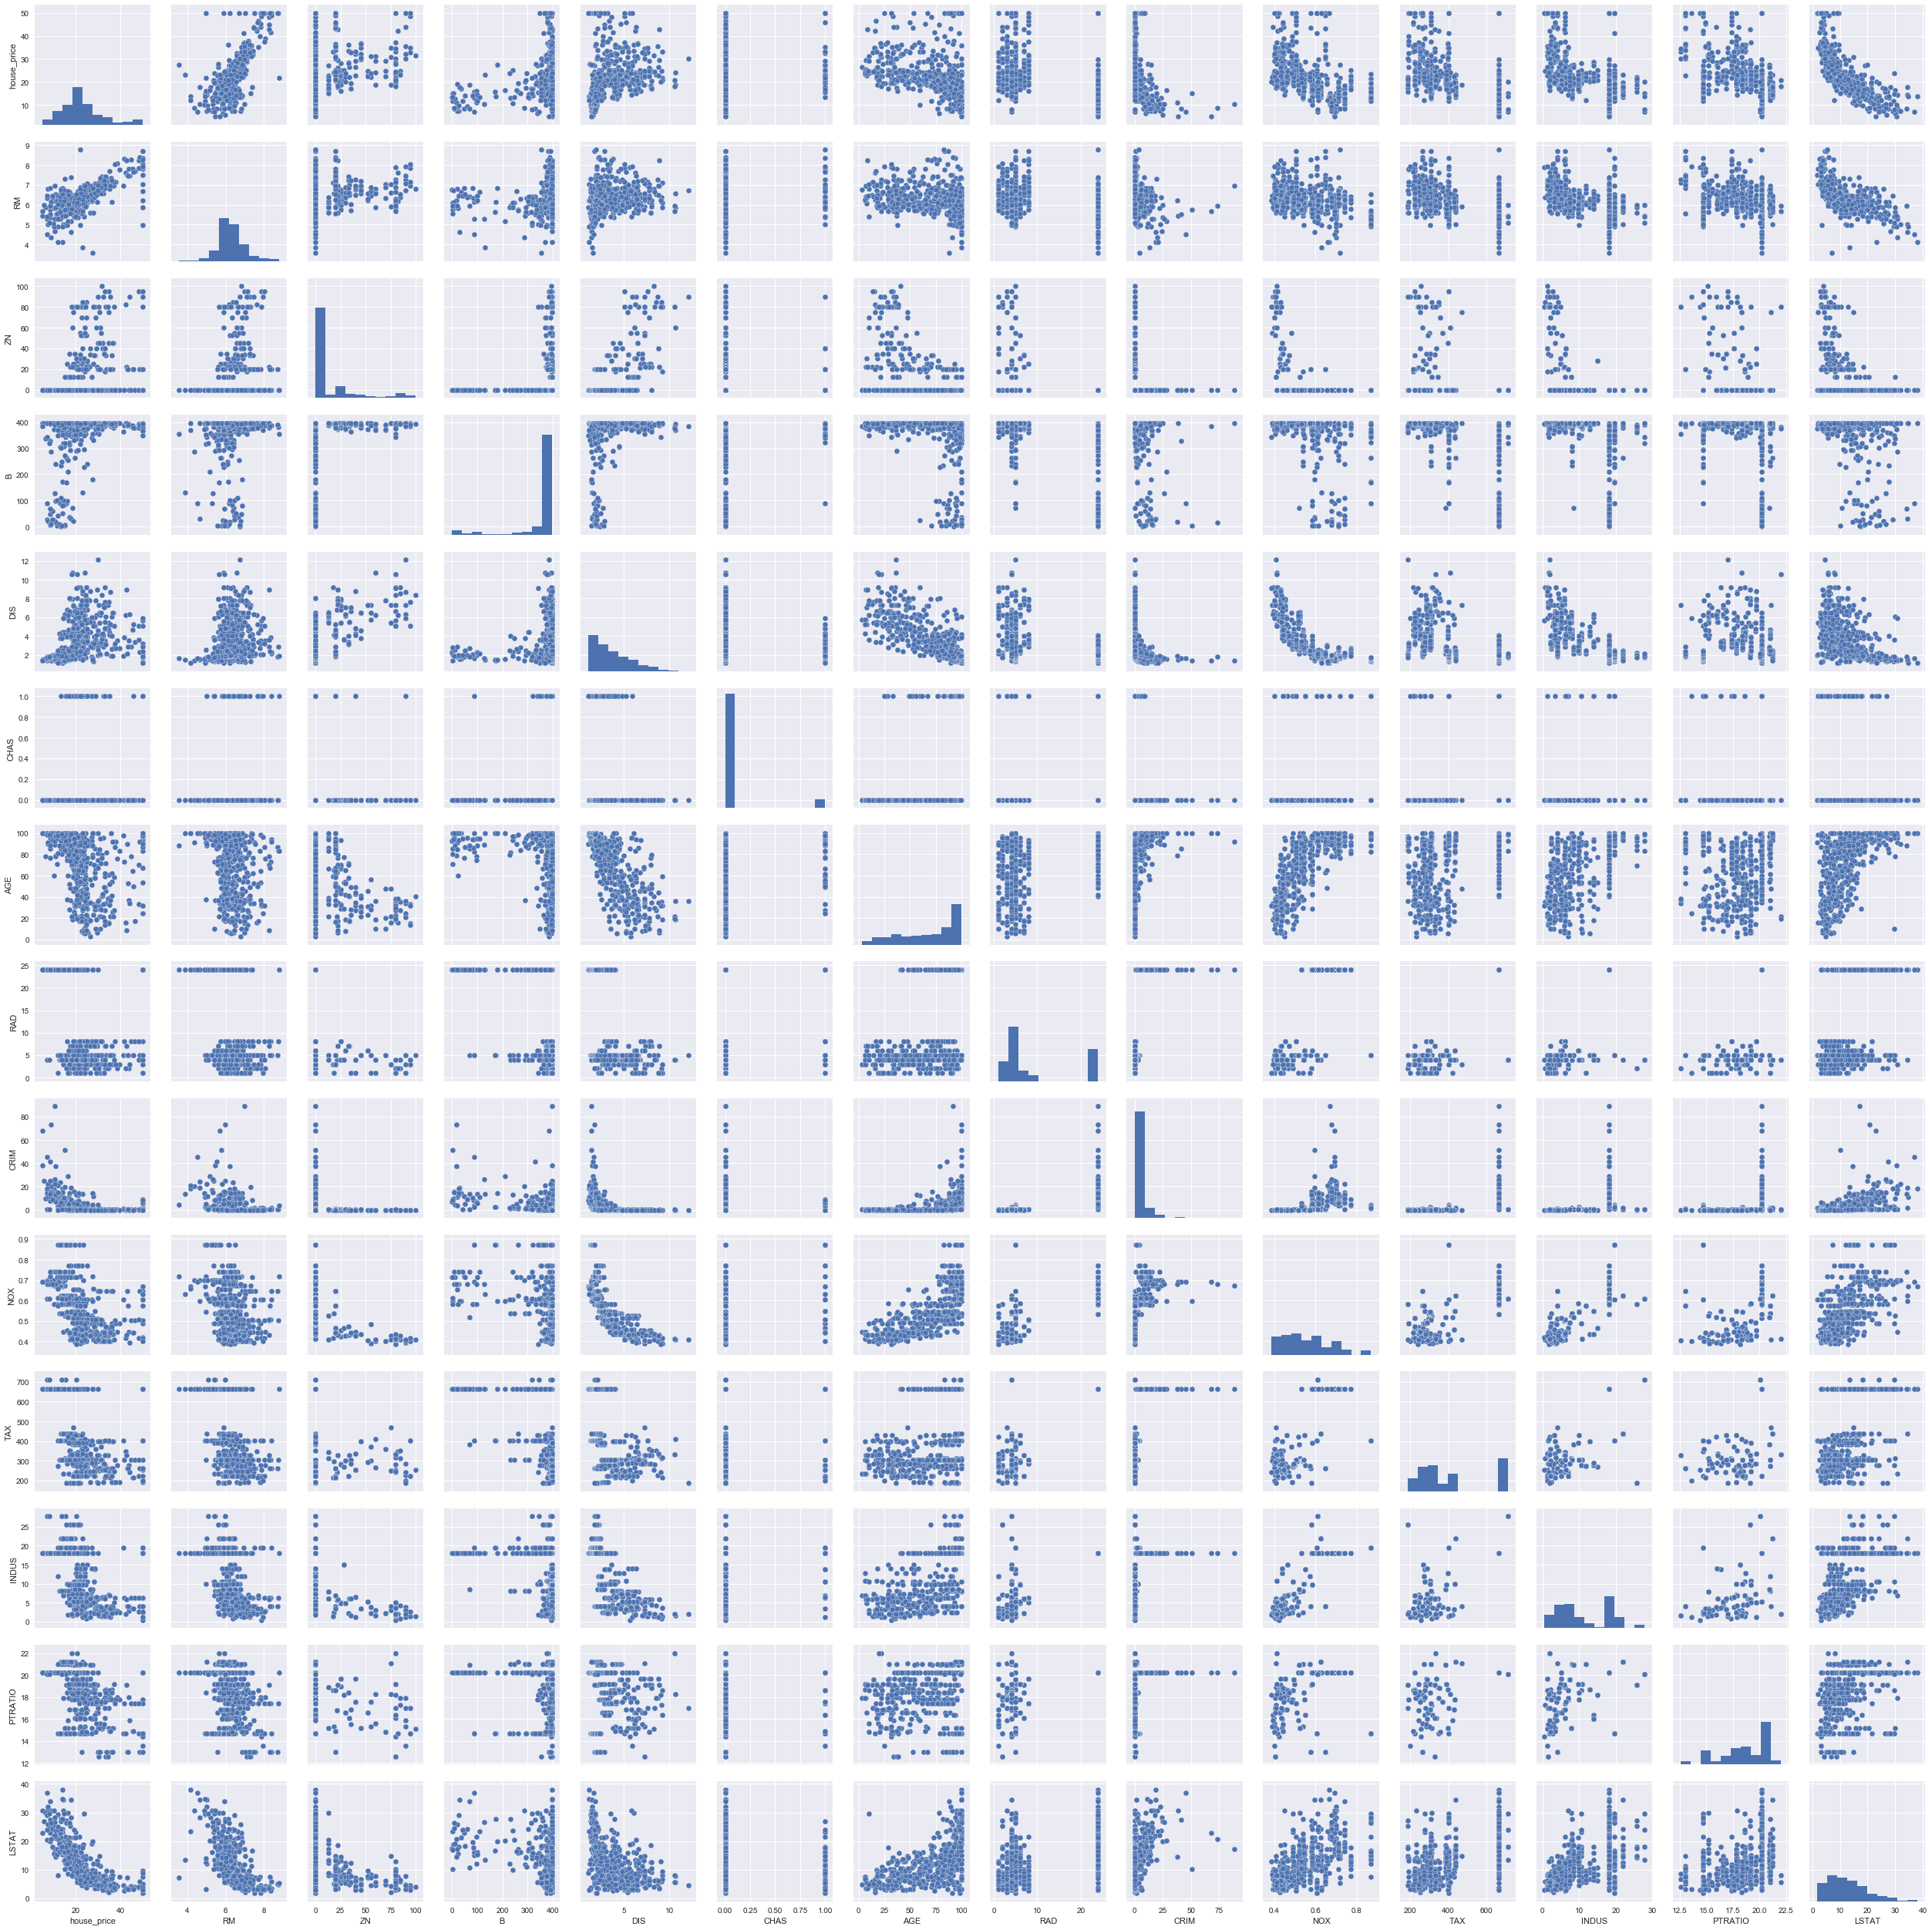

In [52]:
sns.set()
sns.pairplot(df[cols])

わかったこと。

* 少なくとも target (house_price) は 正規分布っぽい。
* 正規分布じゃない特徴量が結構ある
* CHAS（川の周辺）はcategoricalデータのようだ。

## Lasso回帰

In [70]:
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,house_price
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.593761,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.596783,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.647423,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [2]:
from sklearn.linear_model import LassoCV

In [76]:
data_normalized = (boston.data - boston.data.mean())/boston.data.std()

In [73]:
model = LassoCV(alphas=[1, 0.1, 0.01, 0.001, 0.0001]).fit(data_normalized, boston.target)
model.alpha_

0.001

In [74]:
coef = pd.Series(model.coef_, index = boston.feature_names)
coef = coef.sort_values()

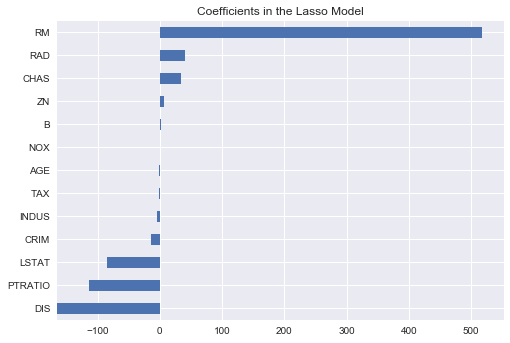

In [75]:
coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

わかったこと。

* RM (平均住居数）が一番影響大きい。正の相関。
* DIS (雇用施設からの距離）、PTRATIO（児童ー教師 比率）、LSTAT（低賃金労働者数）と負の相関。
* RAD（高速道路へのアクセスしやすさ）、CHAS（川の周辺）と小さい正の相関。

参考: http://pythondatascience.plavox.info/scikit-learn/scikit-learnに付属しているデータセット/

| hoge       | piyo        |
|:-----------|------------:|
| CRIM |	人口 1 人当たりの犯罪発生数 | 
| ZN | 25,000 平方フィート以上の住居区画の占める割合 | 
| INDUS | 小売業以外の商業が占める面積の割合 | 
| CHAS | チャールズ川によるダミー変数 (1: 川の周辺, 0: それ以外) | 
| NOX | NOx の濃度 | 
| RM | 住居の平均部屋数 |
| AGE | 1940 年より前に建てられた物件の割合 |
| DIS	| 5 つのボストン市の雇用施設からの距離 (重み付け済) |
| RAD | 環状高速道路へのアクセスしやすさ |
| TAX | $10,000 ドルあたりの不動産税率の総計 |
| PTRATIO | 町毎の児童と教師の比率 |
| B | 町毎の黒人 (Bk) の比率を次の式で表したもの。 1000(Bk – 0.63)^2 |
| LSTAT | 給与の低い職業に従事する人口の割合 (%) |

### 残差分析

(-30, 30)

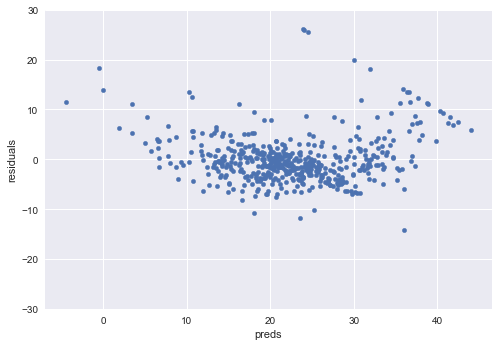

In [78]:
preds = pd.DataFrame({"preds":model.predict(data_normalized), "true":boston.target})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")
plt.ylim(-30,30)

だいたい正規分布っぽくて、良さそうだけど、ちょっと非線形な寄与を拾いきれてないかもね。

In [ ]:
import x